In [1]:
import sys, os
import numpy as np

sys.path.append(os.path.join(os.path.pardir, 'python'))
from tcg_slb.phasediagram import ScipyPDReactiveODE, PDReactiveGrid, PDReactiveGridDiagnostics
from tcg_slb.base import *

In [2]:
pv = repr(sys.version_info.major)+'.'+repr(sys.version_info.minor)
sys.path.append(os.path.join(os.path.pardir, 'database', 'install', 'Fe2SiO4_all_slb_rx', 'lib', 'python'+pv, 'site-packages'))

import py_Fe2SiO4_all_slb_rx as tcgdb
rxn = tcgdb.Fe2SiO4_all_slb_rx()
rxn.report()

Reaction object: Fe2SiO4_all_slb_rx

Phase 0 Fayalite_slb_ph (fa)
     Endmember 0 Fayalite_slb_em : Fe2SiO4_(fa)
Phase 1 Wuestite_slb_ph (wu)
     Endmember 0 Wuestite_slb_em : FeO_(wu)
Phase 2 Quartz_slb_ph (qtz)
     Endmember 0 Quartz_slb_em : SiO2_(qtz)
Phase 3 Ferrosilite_slb_ph (fs)
     Endmember 0 Ferrosilite_slb_em : Fe2Si2O6_(fs)
Phase 4 FeRingwoodite_slb_ph (feri)
     Endmember 0 FeRingwoodite_slb_em : Fe2SiO4_(feri)
Phase 5 Stishovite_slb_ph (st)
     Endmember 0 Stishovite_slb_em : SiO2_(st)

Reaction 0
     Fe2SiO4_(fa) -> 2 FeO_(wu) + SiO2_(qtz)
Reaction 1
     Fe2SiO4_(fa) -> FeO_(wu) + 0.5 Fe2Si2O6_(fs)
Reaction 2
     Fe2SiO4_(fa) -> Fe2SiO4_(feri)
Reaction 3
     Fe2SiO4_(fa) -> 2 FeO_(wu) + SiO2_(st)
Reaction 4
     0.5 FeO_(wu) + 0.5 SiO2_(qtz) -> 0.25 Fe2Si2O6_(fs)
Reaction 5
     0.666667 FeO_(wu) + 0.333333 SiO2_(qtz) -> 0.333333 Fe2SiO4_(feri)
Reaction 6
     SiO2_(qtz) -> SiO2_(st)
Reaction 7
     0.666667 FeO_(wu) + 0.333333 Fe2Si2O6_(fs) -> 0.666667 Fe2SiO

### Setup ODE

In [3]:
ode = ScipyPDReactiveODE(rxn)

#### Temperature, pressure, composition

In [4]:
# initial temperature, pressure and phase volume fraction
Ti = 1150.                # Kelvin
pi = GPa2Bar(23.5)         # bars
Ci0 = [0.8, 0.2]    # unused
i0 =  0                   # initial phase index

#### Initial conditions

In [5]:
mi0 = np.zeros(ode.I)
mi0[i0] = 1.
Cik0 = np.zeros(ode.K)
for i in range(ode.I):
    if ode.Kis[i] == 1:
        Cik0[sum(ode.Kis[:i]):sum(ode.Kis[:i+1])] = 1.
    else:
        Cik0[sum(ode.Kis[:i]):sum(ode.Kis[:i+1])][:] = np.asarray(Ci0)
        
display(mi0, Cik0)

array([1., 0., 0., 0., 0., 0.])

array([1., 1., 1., 1., 1., 1.])

### Solve the system of reactive ODEs at a fixed pressure and temperature

In [6]:
ode.solve(Ti,pi,mi0,Cik0,1000.0)

In [7]:
ode.stime

0.0977865619934164

In [8]:
ode.final_phases(1.e-2)

(array(['Wuestite_slb_ph', 'Stishovite_slb_ph'], dtype='<U20'),
 array(['wu', 'st'], dtype='<U4'))

## Plotting

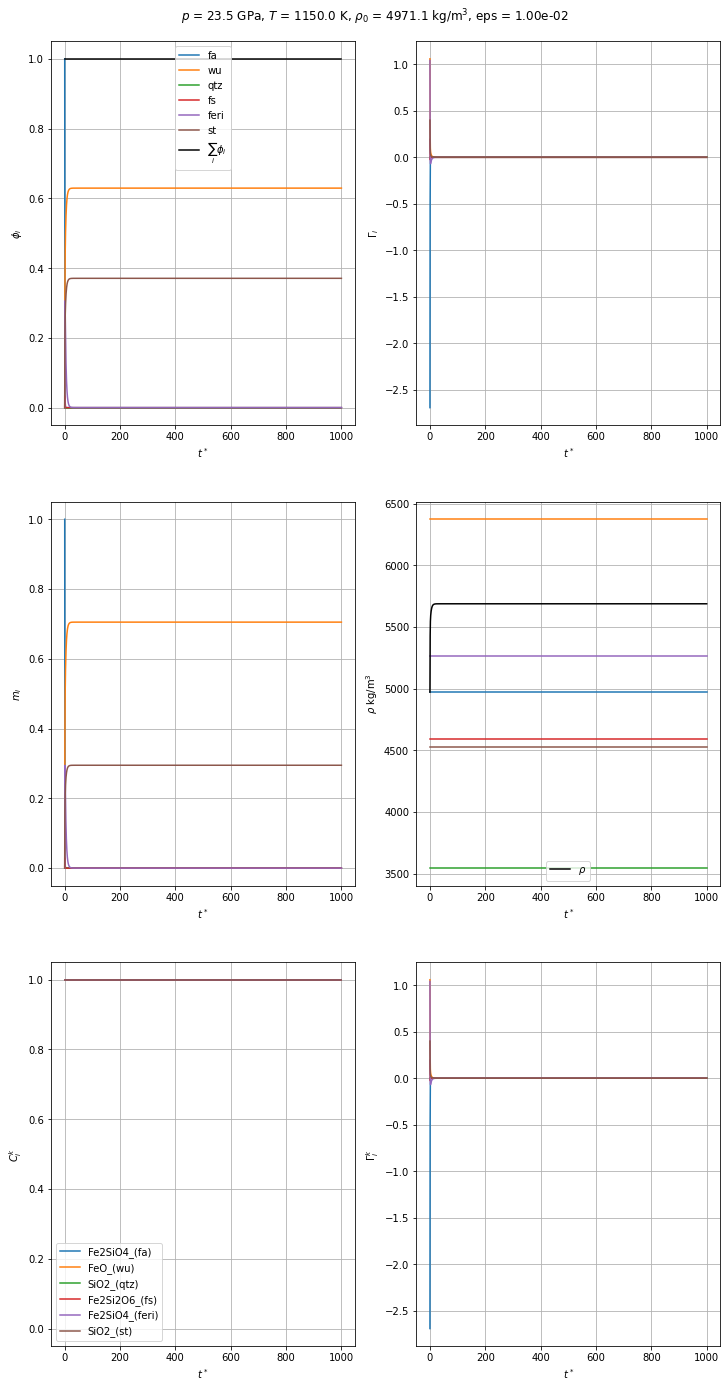

In [9]:
ode.plot()

## Solve for a grid

In [10]:
reload = False

import pickle

filename = os.path.join('output', 'scipy_bdfgrid_fe2sio4_lowp.pickle')

if reload:
    pfile = open(filename, 'rb')
    bdfgrid = pickle.load(pfile)
    pfile.close()
else:
    i0 = 0
    p_n = 60
    p_min = 0.0 + 0.5*29/p_n
    p_max = 29.0 - 0.5*29/p_n
    p_range = np.linspace(p_min, p_max, p_n)
    T_n = 50
    T_min =  800. + 0.5*2000/T_n
    T_max = 2800. - 0.5*2000/T_n
    T_range = np.linspace(T_min, T_max, T_n)
    end = 1e5
    bdfgrid = PDReactiveGrid()
    bdfgrid.solve(rxn, ScipyPDReactiveODE, i0, ['p', 'T'], p_range, T_range, end, **{'Cik0':Cik0})

In [11]:
save = True

if not reload and save:
        pfile = open(filename, 'wb')
        pickle.dump(bdfgrid, pfile)
        pfile.close()

In [12]:
import matplotlib.pyplot as plt

def decorate(pdrgd):
    def new_setup_axes(self,axi):
        img = plt.imread("figures/slb_figure9c.png")
        ip = axi.imshow(img)
        axi.axis('off')
        ax = axi.inset_axes([0.001,0.005,0.998,0.993])
        ax.patch.set_alpha(0.0)
        ax.set_xlim([0.0, 29.0])
        ax.set_ylim([800.0, 2800.0])
        ax.set_ylabel("Temperature (K)")
        ax.set_xlabel("Pressure (GPa)")
        return ax
    
    #replace the display with newdisplay
    pdrgd.setup_axes = new_setup_axes
    
    #return the modified student 
    return pdrgd

bdfdiag = decorate(PDReactiveGridDiagnostics)(rxn,bdfgrid)

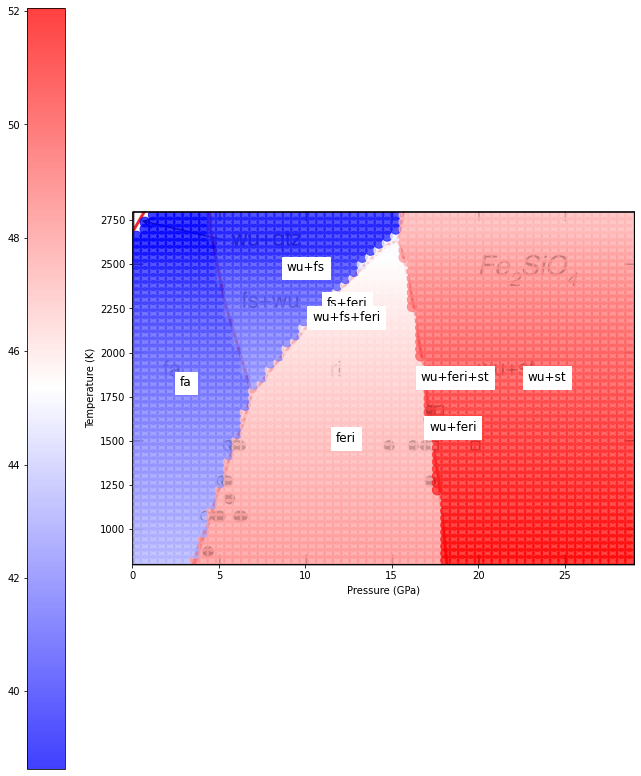

In [13]:
bdfdiag.plot_rho()

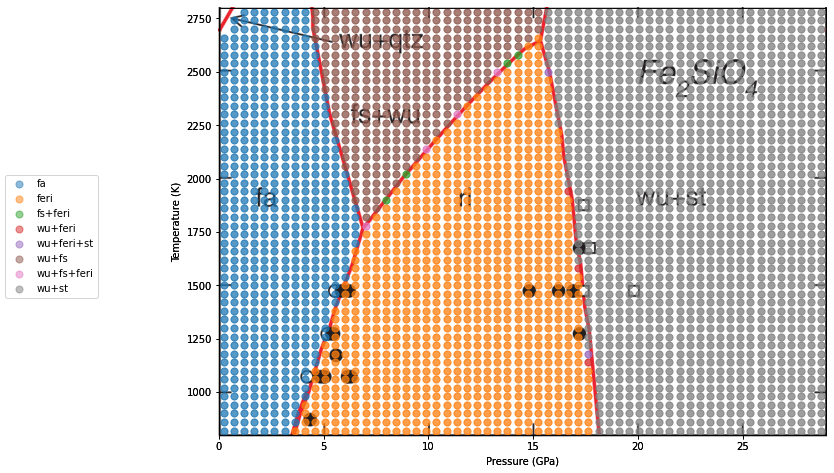

In [14]:
#%matplotlib widget
bdfdiag.plot_phases()

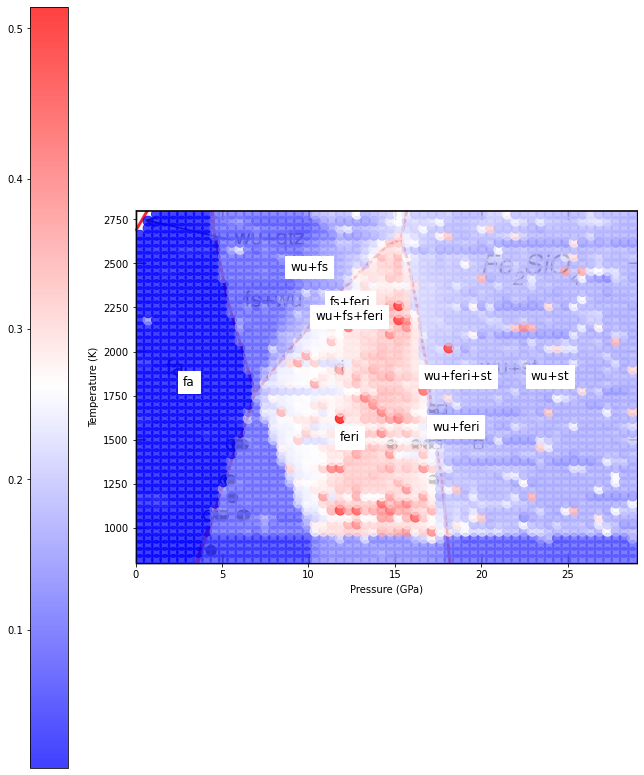

In [15]:
%matplotlib inline
bdfdiag.plot_stime()

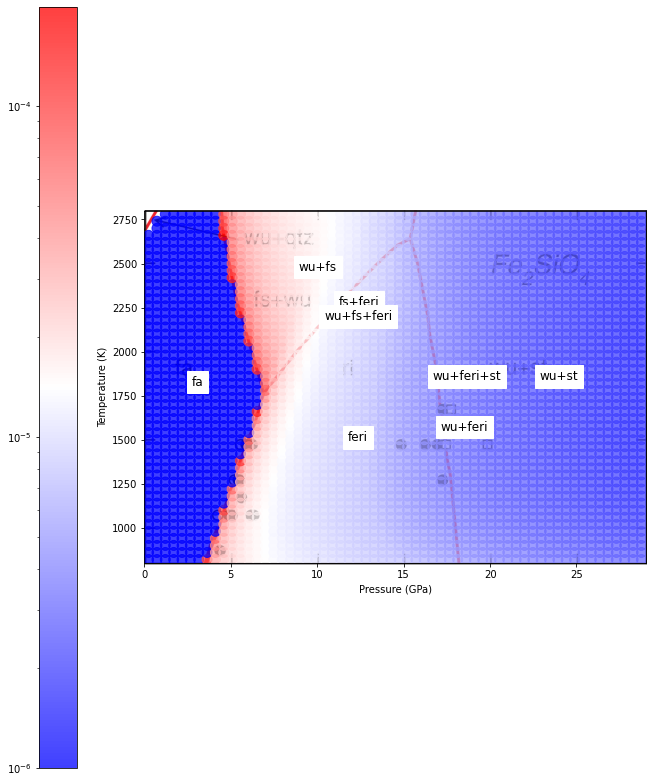

In [16]:
bdfdiag.plot_mindt()

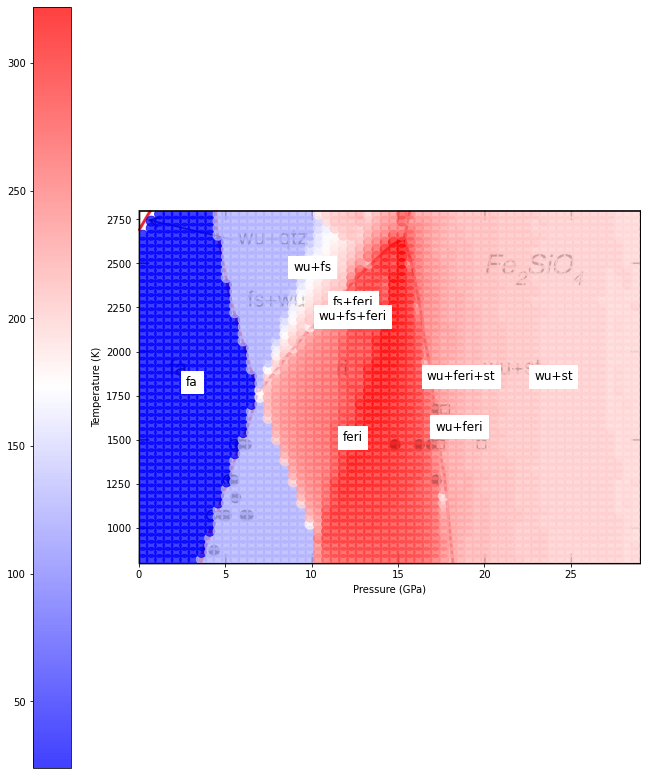

In [17]:
bdfdiag.plot_ndt()